Importing modules

In [11]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
from IPython import display

Loading datasets

In [2]:
(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.mnist.load_data()
#(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.fashion_mnist.load_data()

Preprocessing functions


In [3]:
def preprocData(dSet):
    dSetRes=dSet.reshape(dSet.shape[0],-1).T/255.0
    dSetMean=np.mean(dSetRes,axis=1).reshape(-1,1)
    return(dSetRes,dSetMean)
rm=np.random.RandomState(5000).permutation(xTrain.shape[0])
xTrainPreproc,trainSetMean=preprocData(xTrain)
xTrainPreproc=xTrainPreproc[:,rm]
xTestPreproc,_=preprocData(xTest)


Make dataset

In [4]:
trainSet=tf.data.Dataset.from_tensor_slices(xTrainPreproc.T).shuffle(xTrainPreproc.shape[1]).batch(100)
testSet=tf.data.Dataset.from_tensor_slices(xTestPreproc.T).shuffle(xTestPreproc.shape[1]).batch(100)

VAE class

In [5]:
class VAE(tf.keras.Model):
    def __init__(self, inDim,hidDim,latentDim,numGeneratedExamples):
        super(VAE,self).__init__()
        self.encModel=tf.keras.Sequential([tf.keras.layers.Input(shape=(inDim,)),
                                           tf.keras.layers.Dense(units=hidDim,activation='relu'),
                                           tf.keras.layers.Dense(units=2*latentDim)])
        self.decModel=tf.keras.Sequential([tf.keras.layers.Input(shape=(latentDim,)),
                                           tf.keras.layers.Dense(units=hidDim,activation='relu'),
                                           tf.keras.layers.Dense(units=inDim,activation=None)])
        self.latentDim=latentDim
        self.numExamples=numGeneratedExamples
    @tf.function
    def sample(self,eps=None):
        if(eps is None):
            eps=tf.random.normal(shape=(self.numExamples,self.latentDim))
        return(self.decode(eps,apply_sigmoid=True))
    def encode(self,x):
        mean, logvar = tf.split(self.encModel(x), num_or_size_splits=2, axis=1)
        return mean,logvar 
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    def decode(self, z, apply_sigmoid=False):
        logits = self.decModel(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


Initialize optimizer, distribution and train step function

In [6]:
optimizer = tf.keras.optimizers.Adam()


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=tf.cast(x,tf.float32))
    logpx_z = -tf.reduce_sum(cross_ent, axis=1)
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))



Hyperparameters for training

In [7]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latentDim = 2
numExamplesToGenerate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[numExamplesToGenerate, latentDim])
inDim=xTrainPreproc.shape[0]
hidDim=100
model = VAE(inDim,hidDim,latentDim,numExamplesToGenerate)


Helper functions to generate and save images

In [8]:
def generate_and_save_images(model,  test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(predictions[i, :].numpy().reshape(28,28), cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


take test set batch 

In [9]:
for b in testSet:
    break

train and generate

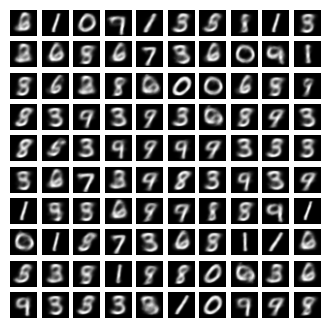

Epoch: 1.0000, Test set ELBO: -155.6441


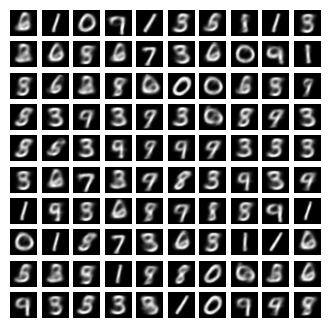

Epoch: 2.0000, Test set ELBO: -155.4261


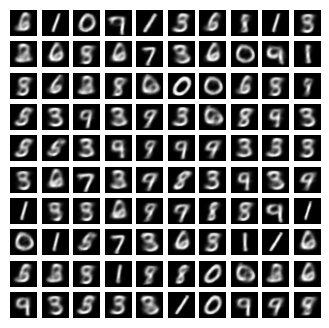

Epoch: 3.0000, Test set ELBO: -155.2304


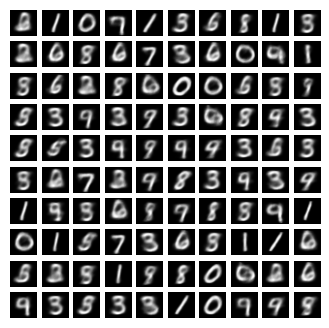

Epoch: 4.0000, Test set ELBO: -155.0810


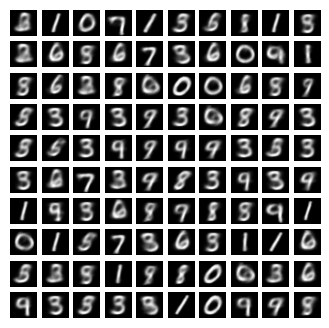

Epoch: 5.0000, Test set ELBO: -154.8016


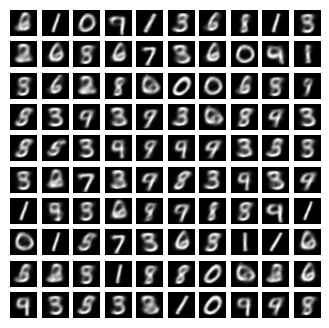

Epoch: 6.0000, Test set ELBO: -154.9310


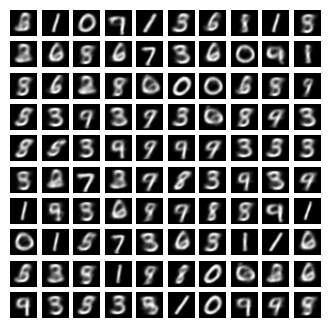

Epoch: 7.0000, Test set ELBO: -154.6953


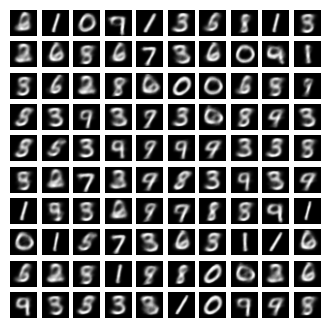

Epoch: 8.0000, Test set ELBO: -154.3351


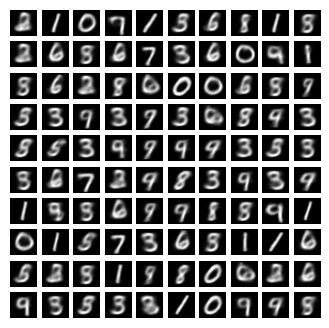

Epoch: 9.0000, Test set ELBO: -154.1636


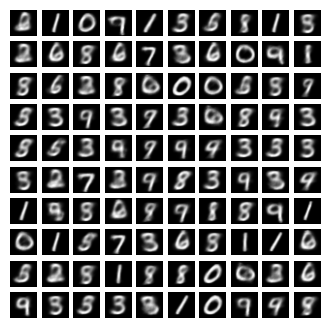

Epoch: 10.0000, Test set ELBO: -154.1024


In [15]:
for epoch in range(1, epochs + 1):
    # start_time = time.time()
    for train_x in trainSet:
        train_step(model, train_x, optimizer)
    #end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in testSet:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    generate_and_save_images(model,b)
   # display.clear_output(wait=1)
    print(f'Epoch: {epoch:0.4f}, Test set ELBO: {elbo:0.4f}')
